# **Project: Classification Metrics**

This project will focus on creating and improving a model for the Tanazania Water Pump dataset. Our goal is to create a model to predict whether a water pump is functional, non-functional, or functional needs repair.


# I. Wrangle Data

In [35]:
%%capture
!pip install category_encoders plotly

In [2]:
#mount google drive where the .csv files are stored
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#update working directory on google drive
%cd /content/drive/My Drive/Kaggle/bloomtech-water-pump-challenge

/content/drive/My Drive/Kaggle/bloomtech-water-pump-challenge


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

In [41]:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path, 
                                  na_values=[0, -2.000000e-08],
                                  parse_dates=['date_recorded']),
                      pd.read_csv(tv_path)).set_index('id')
    else:
        df = pd.read_csv(fm_path, 
                         na_values=[0, -2.000000e-08],
                         parse_dates=['date_recorded'],
                         index_col='id')

    # Drop constant columns
    df = df.drop(columns=['recorded_by'])

    # Create age feature
    df['pump_age'] = df['date_recorded'].dt.year - df['construction_year']
    df = df.drop(columns=['date_recorded', 'construction_year'])

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df = df.drop(columns=drop_cols)
    df = df.drop(columns= ['num_private', 'amount_tsh'])

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(100).T.duplicated().index
                 if df.head(100).T.duplicated()[col]]
    df = df.drop(columns=dupe_cols)
    manual_dupe_cols = ['source_type', 'waterpoint_type', 'extraction_type', 'extraction_type_group', 'region_code', 'quality_group', 'payment', 'management_group', 'scheme_management']
    df = df.drop(columns= manual_dupe_cols)             

    return df

Using the above `wrangle` function to read `train_features.csv` and `train_labels.csv` into the DataFrame `df`, and `test_features.csv` into the DataFrame `X_test`.

In [42]:
df = wrangle('train_features.csv', 'train_labels.csv')
X_test = wrangle('test_features.csv')

# II. Split Data

Split DataFrame `df` into a feature matrix `X` and the target vector `y`. We want to predict `'status_group'`.

In [43]:
target = 'status_group'
X = df.drop(columns= target)
y = df[target]

Using a randomized split, we will divide `X` and `y` into a training set (`X_train`, `y_train`) and a validation set (`X_val`, `y_val`).

In [44]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.2, random_state = 42)

# III. Establish Baseline

Baseline == majority class in `y_train`, what percentage of our training observations it represents.

In [45]:
baseline_acc = y.value_counts(normalize=True).max()
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5429828068772491


# IV. Build Models

In [46]:
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy = 'median'),
    RandomForestClassifier(
        max_depth = 25, 
        random_state = 42, 
        n_jobs = -1, 
        max_samples = 0.4,
        n_estimators = 175
        )
)

model.fit(X_train, y_train);

# V. Check Metrics

Calculating the training and validation accuracy scores for `model`.

In [47]:
training_acc = model.score(X_train, y_train)
val_acc = model.score(X_val, y_val)

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.9159212880143113
Validation Accuracy Score: 0.7702283249158249


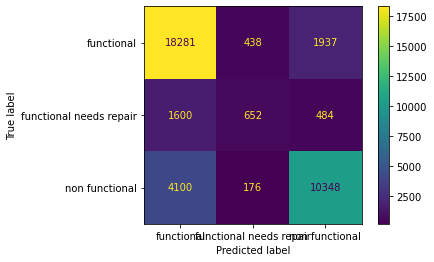

In [48]:
# Plot 3x3 confusion matrix

y_pred= model.predict(X_val)

ConfusionMatrixDisplay.from_estimator(
    model,
    X_val,
    y_val,
    values_format = '.0f'
);

In [49]:
# Print classification report 

print(classification_report(
    y_val,
    model.predict(X_val)
))

                         precision    recall  f1-score   support

             functional       0.76      0.89      0.82     20656
functional needs repair       0.52      0.24      0.33      2736
         non functional       0.81      0.71      0.76     14624

               accuracy                           0.77     38016
              macro avg       0.70      0.61      0.63     38016
           weighted avg       0.76      0.77      0.76     38016



In [50]:
module4_submission = pd.DataFrame({'status_group': model.predict(X_test)}, index= X_test.index)

In [51]:
module4_submission.to_csv('module4_submission.csv')

# VI. Tune Model

Usually, we use this part of the ML workflow to adjust the hyperparameters of the our model to increase performance based on metrics like accuracy. Today, we'll use it to help maximize the impact of our water pump repairs when resources are scarce. What if we only had funds to repair 100 water pumps?

(This activity is based on a [post](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050) by Michael Brady.)

We will identify the observations in the test set where the model is more than 95% certain that a pump is `'non-functional'`.

In [52]:
X_test_nf = pd.DataFrame({'y_pred_proba': model.predict_proba(X_test)[:, -1], 'y_pred': model.predict(X_test)}, index= X_test.index)

In [53]:
combined_df_nf = pd.merge(X_test, X_test_nf, on='id')

In [54]:
threshold = 0.95

mask = (combined_df_nf['y_pred_proba']>threshold)
sample = combined_df_nf[mask]

In [55]:
X_test_nf = sample.sort_values(by='population', ascending=False).head(100)

# VII. Communicate Results

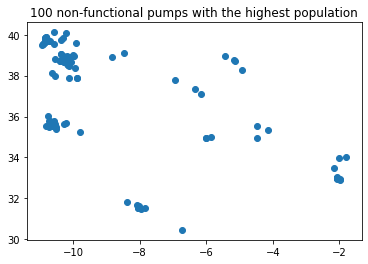

In [56]:
plt.scatter(X_test_nf['latitude'], X_test_nf['longitude'])
plt.title('100 non-functional pumps with the highest population');

In [57]:
mapbox_access_token = 'pk.eyJ1IjoibWFpeWExMSIsImEiOiJjbGZzc2FiOGIwMWE4M2RxcHhyMjlvd3UzIn0.ez1Qh_dtHkxgK4Xe6WGA5w'
px.set_mapbox_access_token(mapbox_access_token)

In [58]:
fig = px.scatter_mapbox(X_test_nf, lat="latitude", lon="longitude", color="population", size='population', hover_data=['region', 'basin', 'population'],
                   color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=10)
fig.show(renderer='colab')